# Cross-validation 
> Implement cross-validation to evaluate models on historical data

Time series cross-validation is a method for evaluating how a model would have performed on historical data. It works by defining a sliding window across past observations and predicting the period following it. It differs from standard cross-validation by maintaining the chronological order of the data instead of randomly splitting it.

This method allows for a better estimation of our model's predictive capabilities by considering multiple periods. When only one window is used, it resembles a standard train-test split, where the test data is the last set of observations, and the training set consists of the earlier data.

The following graph showcases how time series cross-validation works. 

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

In this tutorial we'll explain how to perform cross-validation in `NeuralForecast`. 

**Outline:**
1. Install NeuralForecast

2. Load and plot the data 

3. Train multiple models using cross-validation

4. Evaluate models and select the best for each series

5. Plot cross-validation results

:::{.callout-warning collapse="true"}
## Prerequesites
This Guide assumes basic familiarity with NeuralForecast. For a minimal example visit the [Quick Start](./Getting_Started.ipynb)
:::

## 1. Install NeuralForecast

In [ ]:
%%capture
!pip install neuralforecast

## 2. Load and plot the data 

We'll use pandas to load the hourly dataset from the [M4 Forecasting Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128), which has been stored in a parquet file for efficiency. 

In [ ]:
import pandas as pd
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


The input to `NeuralForecast` should be a data frame in long format with three columns: `unique_id`, `ds`, and `y`.

- `unique_id` (string, int, or catefory): A unique identifier for each time series. 

- `ds` (int or datestamp): An integer indexing time or a datestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS.

- `y` (numeric): The target variable to forecast.

The dataset contains unique time series. To reduce the total execution time, we will use only the first 10. 

In [ ]:
uids = Y_df['unique_id'].unique()[:10] # Select 10 ids to make the example run faster
Y_df = Y_df.query('unique_id in @uids').reset_index(drop=True)

To plot the series, we'll can use the `plot` method from the `StatsForecast` class. 

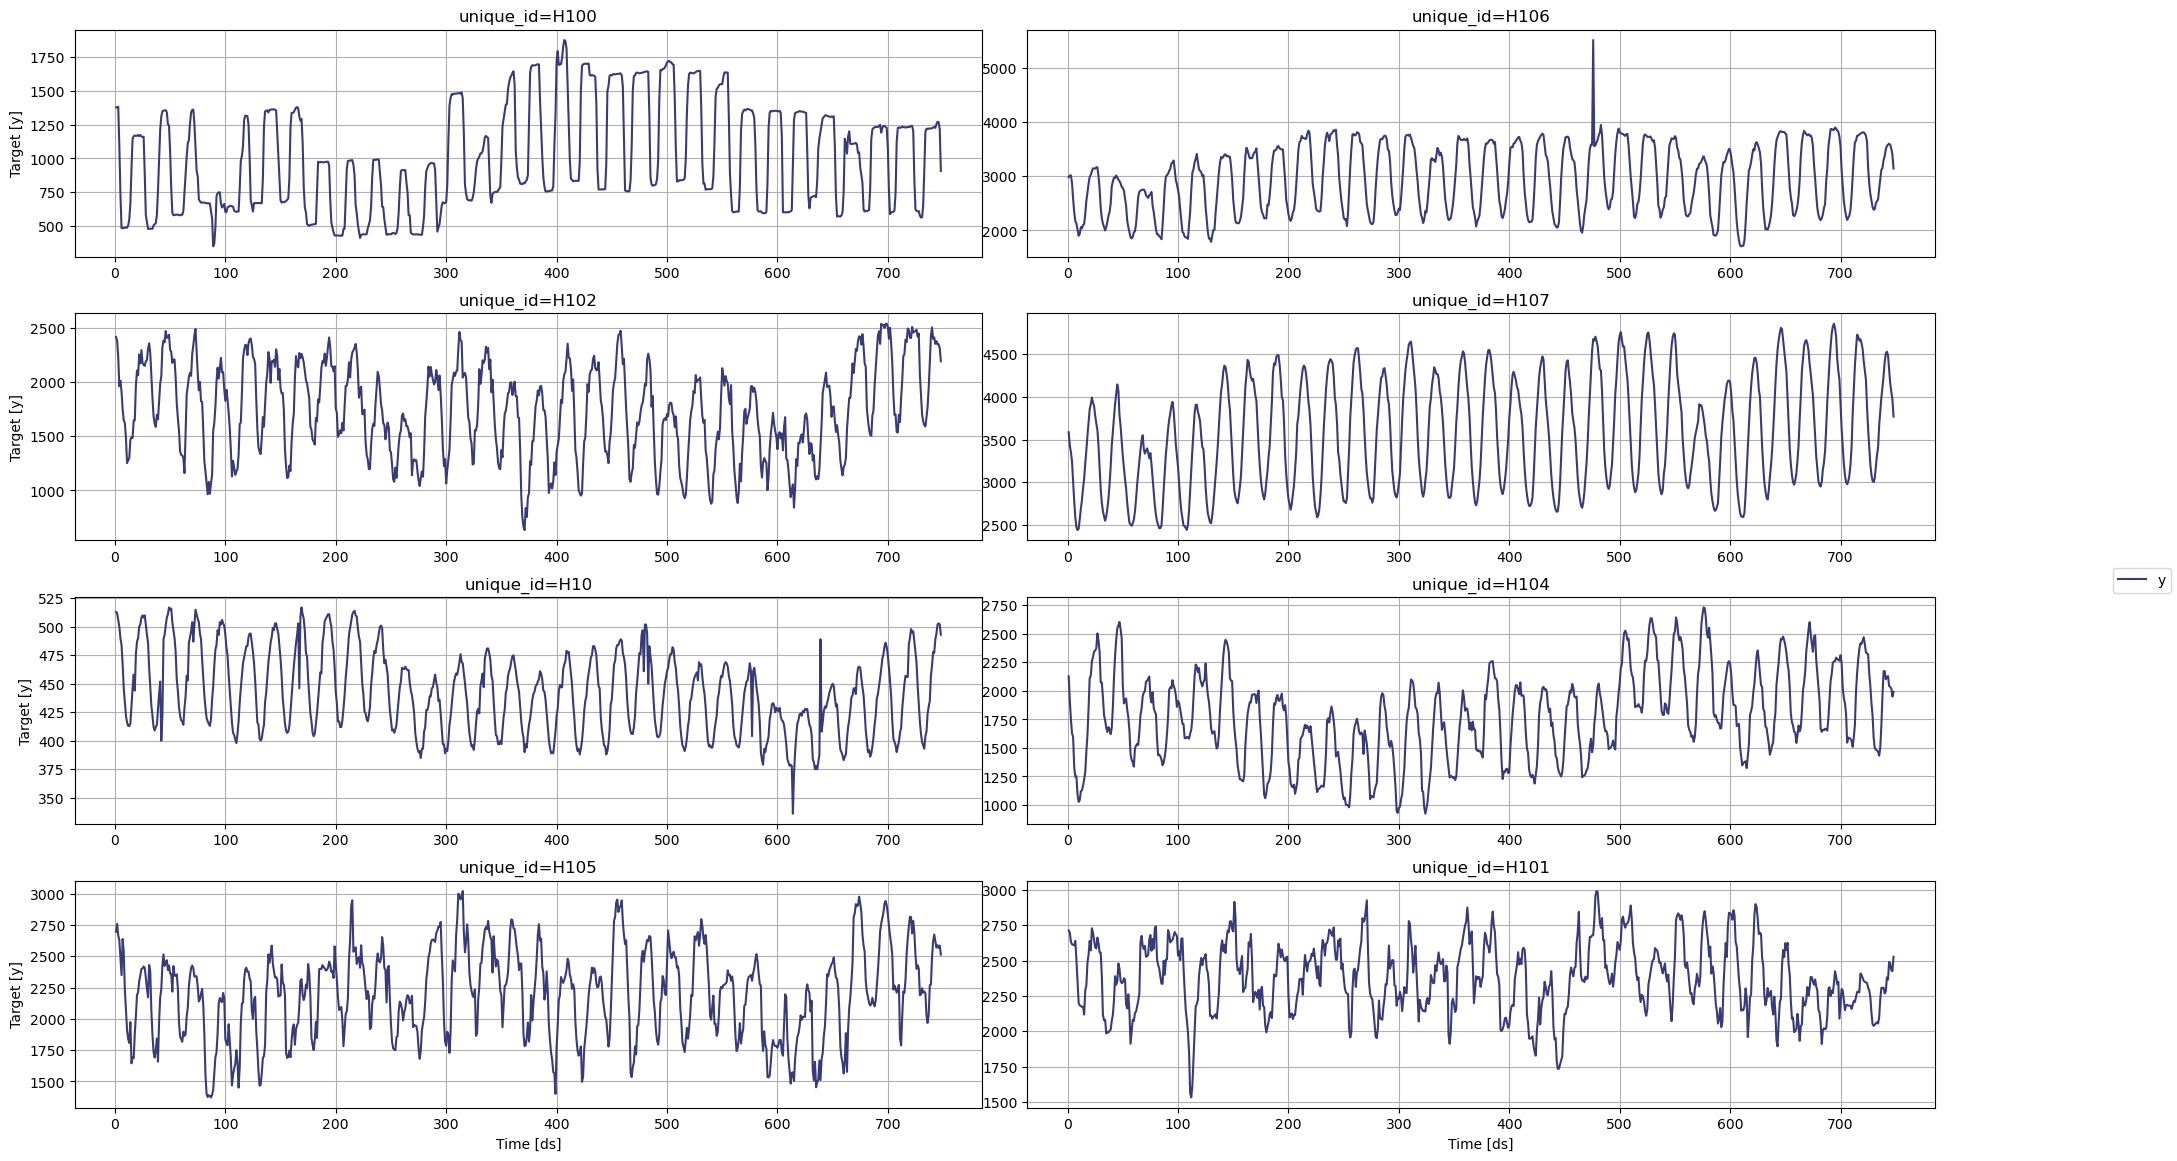

In [ ]:
from statsforecast import StatsForecast
StatsForecast.plot(Y_df)

## 3. Train multiple models using cross-validation

We'll train different models from `neuralforecast` using the `cross-validation` method to decide which one perfoms best on the historical data. To do this, we need to import the `NeuralForecast` class and the models that we want to compare. 

In [ ]:
from neuralforecast import NeuralForecast 
from neuralforecast.auto import AutoNHITS, AutoLSTM

In this tutorial, we'll use `auto` models, which automate the hyperparameter optimization process. To instantiate an `auto` model, you need to define the following parameters: 

- `h`: The forecasting horizon

- `loss`: The loss function to optimize.

- `config`: The hyperparameter search space. Default is `None`, and for this value, the `Auto` class will use a pre-defined suggested hyperparameter space.

- `search_alg`: The search algorithm to use. Default is random search. 

- `num_samples`: The number of configurations to explore. 

The forecasting horizon will be the same as in the M4 Competition, which is 48 steps ahead, so we'll set `horizon=48`. We'll use the Multi Quantile Loss (MQLoss) from `neuralforecast.losses.pytorch`, defined as the sum of the quantile losses for each target quantile. The quantile loss for a single quantile $\tau$ is given by:

\begin{equation*}
L_\tau(y, \hat{y}) = \begin{cases}
\tau \cdot (y - \hat{y}) & \text{if } y \geq \hat{y} \\
(1 - \tau) \cdot (\hat{y} - y) & \text{if } y < \hat{y}
\end{cases}
\end{equation*}

with $y$ the actual value and $\hat{y}$ the predicted value. For more details, see [here](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#multi-quantile-loss-mqloss). 

In [ ]:
from neuralforecast.losses.pytorch import MQLoss

horizon = 48 
nf = NeuralForecast(
    models = [ # we'll use the default config and search_alg paramaters 
        AutoNHITS(h=horizon, loss=MQLoss(), num_samples=1),
        AutoLSTM(h=horizon, loss=MQLoss(), num_samples=1), 
    ], 
    freq = 1
)

The `cross_validation` method takes the following arguments: 

- `df`: The data frame in the format described in section 2. 

- `step_size` (int): The number of steps to move the window forward. For example, when using daily data and `step_size=7`, the window moves a week forward. Default is 1.

- `n_windows` (int): The number of windows to evaluate. 

In [ ]:
%%capture
cv_df = nf.cross_validation(Y_df, n_windows=3)

2024-02-21 11:11:44,491	INFO worker.py:1724 -- Started a local Ray instance.
2024-02-21 11:11:45,228	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2024-02-21 11:11:45,230	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
Seed set to 15
2024-02-21 11:13:42,910	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
Seed set to 10


In [ ]:
cv_df.head()

,ds,cutoff,AutoNHITS-median,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoLSTM-median,AutoLSTM-lo-90,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-90,y
unique_id,,,,,,,,,,,,,
H1,699,698,741.582275,706.152771,715.114685,766.681519,776.454224,715.913940,637.801270,662.411316,758.362305,774.381897,739.0
H1,700,698,704.706116,661.089539,667.496887,730.767883,746.342468,670.851746,567.694824,596.903198,740.003479,774.423645,684.0
H1,701,698,638.851562,604.328491,609.395325,676.230896,695.120544,626.830200,506.483093,547.707031,716.202332,748.814209,619.0
H1,702,698,573.647827,537.494934,538.641052,602.185425,625.901245,567.366943,455.341797,490.633362,649.698730,690.836975,565.0
H1,703,698,513.462280,483.188995,486.862427,544.715942,559.164917,512.811646,399.501404,440.068481,600.238220,651.876343,532.0


The output of the `cross-validation` method is a data frame that includes the following columns:

- `unique_id`: The unique identifier for each time series. 

- `ds`: The datestamp or temporal index. 

- `cutoff`: The last datestamp or temporal index used in that cross-validation window. 

- `"model"`: Columns with the model’s point forecasts (median) and prediction intervals. By default, the 80 and 90% prediction intervals are included.

- `y`: The actual value.

## 4. Evaluate models and select the best for each series

To evaluate the point forecasts of the models, we'll use the Root Mean Squared Error (RMSE), defined as the square root of the mean of the squared differences between the actual and the predicted values. 

\begin{equation*}
RMSE = \sqrt{\frac{1}{h}\sum_{i=1}^{h}(y_i - \hat{y}_i)^2}
\end{equation*}


For convenience, we'll use the `rmse` and the `accuracy` functions from `datasetsforecast`.

In [ ]:
from datasetsforecast.losses import rmse
from datasetsforecast.evaluation import accuracy

The `accuracy` function takes several arguments. The ones we'll use here are explained below: 

- `Y_hat_df`(pandas DataFrame): A data frame with the actual values and the forecasts to evaluate. By default, assumes the target variable is `y`. 

- `metrics` (List): List with the metrics to compute, in this case, the RMSE. 

- `agg_by` (List): List of columns to aggregate the results, in this case `unique_id`.

In order to use the `accuracy` function, we'll need to remove the word `median` from the column names. 

In [ ]:
cv_df.columns = cv_df.columns.str.replace('-median', '')
cv_df = cv_df.reset_index()

In [ ]:
evaluation_df = accuracy(cv_df, [rmse], agg_by=['unique_id'])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df

,metric,unique_id,AutoNHITS,AutoLSTM,best_model
0,rmse,H1,36.681105,41.809735,AutoNHITS
1,rmse,H10,7.559592,11.130644,AutoNHITS
2,rmse,H100,108.261940,200.657629,AutoNHITS
3,rmse,H101,129.395014,126.215967,AutoLSTM
4,rmse,H102,389.195806,238.023273,AutoLSTM
5,rmse,H103,4512.211073,6160.149717,AutoNHITS
6,rmse,H104,129.061472,144.204821,AutoNHITS
7,rmse,H105,175.846938,132.703129,AutoLSTM
8,rmse,H106,173.915044,169.759064,AutoLSTM
9,rmse,H107,201.515791,113.121846,AutoLSTM


We can summarize the results to see how many times each model won. 

In [ ]:
summary_df = evaluation_df.groupby(['metric', 'best_model']).size().sort_values().to_frame()

summary_df = summary_df.reset_index()
summary_df.columns = ['metric', 'model', 'num. of unique_ids']
summary_df

,metric,model,num. of unique_ids
0,rmse,AutoLSTM,5
1,rmse,AutoNHITS,5


With this information, we now know which model performs best for each series.

## 5. Plot cross-validation results

To visualize the cross-validation results, we will use the plot method from the `StatsForecast` class again. We will need to rename the `y` column in the cross-validation data frame to avoid duplicates with the original data frame. We will also exclude the `cutoff` column and use the `max_insample_length argument` to plot only the last 200 observations for better visualization. 

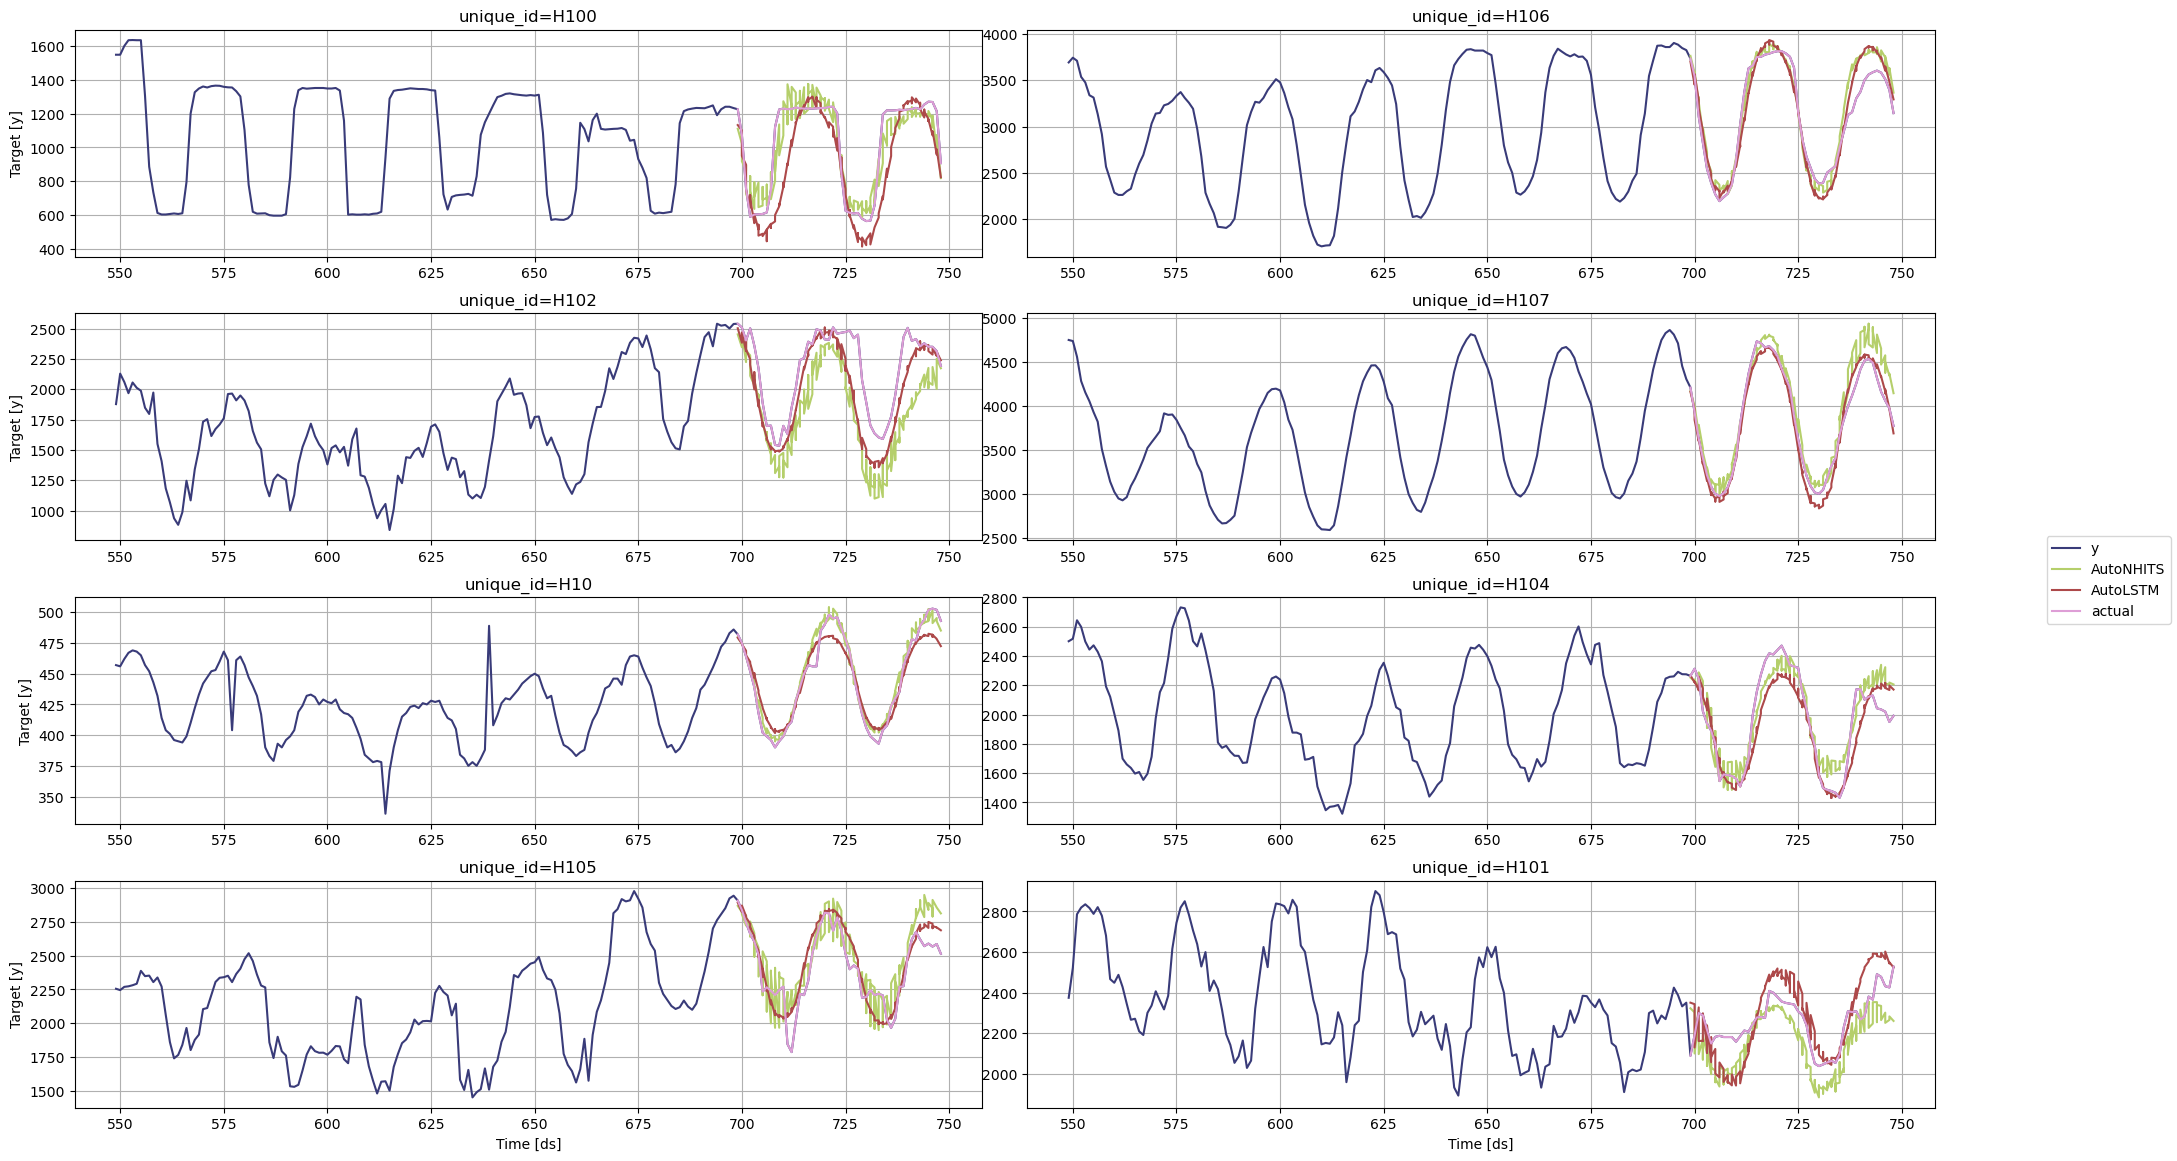

In [ ]:
cv_df.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values 
StatsForecast.plot(Y_df, cv_df.loc[:, cv_df.columns != 'cutoff'], max_insample_length=200) 